In [1]:
import pandas as pd
import os
import matplotlib.pyplot as plt

import tensorflow as tf
from tensorflow import keras
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split

plt.style.use("bmh")
plt.rcParams["figure.figsize"] = (15,10)

## Load and pre-process data

### 1) Global parameters

In [2]:
SOURCE_PATH = os.path.dirname(os.getcwd())

N_JOBS = 1  # number of jobs to run in parallel
N_SPLITS = 10  # number of splits (k) to be made within the k fold cv
N_ITER = 50  # number of parameter settings that are sampled
SEED = 2294
VERBOSE = True
INPUTS_PATH = os.path.join(SOURCE_PATH, "data", "inputs")
OUTPUTS_PATH = os.path.join(SOURCE_PATH, "data", "outputs")
DATASET_NAMES = ["betadgp_covdgp_data", "betadgp_beta2x2_data", "betadgp_data"]
TARGET_NAME = "betas_dgp"
MODEL_TAG = "ffnn"
STANDARDIZE = True
TRAIN_SIZE = 0.7 # size of training data (in %)

VALIDATION_SIZE = 0.2

### 2) Local parameters

In [3]:
DIR_NAMES = os.listdir(os.path.join(INPUTS_PATH))

inputs_path = INPUTS_PATH
target_name = TARGET_NAME
standardize = STANDARDIZE
train_size = TRAIN_SIZE

dir_name = DIR_NAMES[0]
d_name = DATASET_NAMES[0] 

In [4]:
train_data = pd.read_csv(os.path.join(inputs_path, dir_name, d_name + ".csv"))
train_data.set_index(["Var1", "Var2"], inplace=True)
y_train = train_data[[target_name]].to_numpy()
X_train = train_data.drop([target_name], axis=1).to_numpy()

test_data = pd.read_csv(os.path.join(inputs_path, dir_name, d_name + "_test.csv"))
test_data.set_index(["Var1", "Var2"], inplace=True)
y_test = test_data[[target_name]].to_numpy()
X_test = test_data.drop([target_name], axis=1).to_numpy()

if standardize:
    X_train, X_validation, y_train, y_validation = train_test_split(X_train, y_train, train_size=train_size)

    scaler = StandardScaler()
    X_train_zscore = scaler.fit_transform(X_train)
    X_validation_zscore = scaler.transform(X_validation)
    X_test_zscore = scaler.transform(X_test)

In [5]:
X_train.shape

(15749, 1)

In [6]:
X_validation.shape

(6751, 1)

In [7]:
train_data.tail()

betas_dgp   cov_dgp
Var1 Var2                     
150  146         0.0  0.025080
     147         0.0 -0.025383
     148         0.0  0.045941
     149         0.0 -0.001684
     150         0.0  1.000000

array([[<AxesSubplot:title={'center':'betas_dgp'}>]], dtype=object)

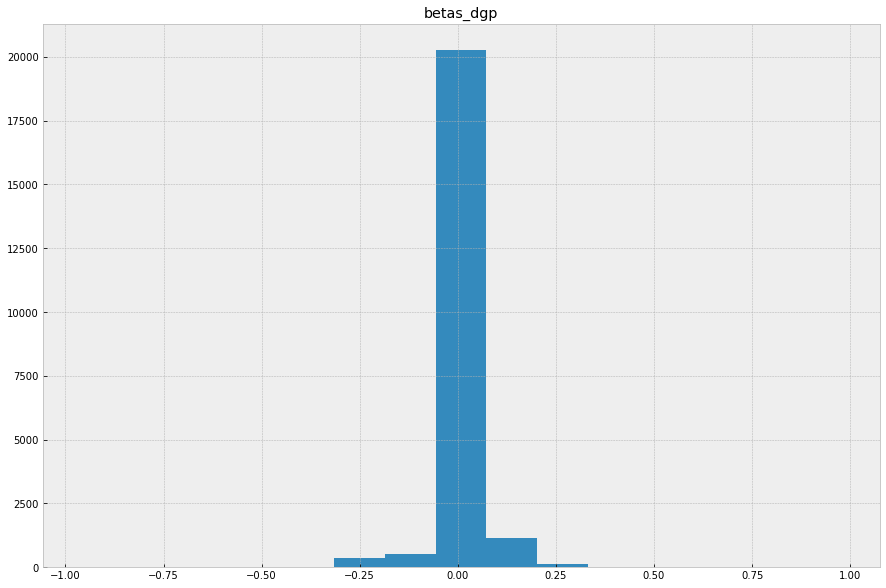

In [8]:
train_data[["betas_dgp"]].hist(bins=15)

array([[<AxesSubplot:title={'center':'cov_dgp'}>]], dtype=object)

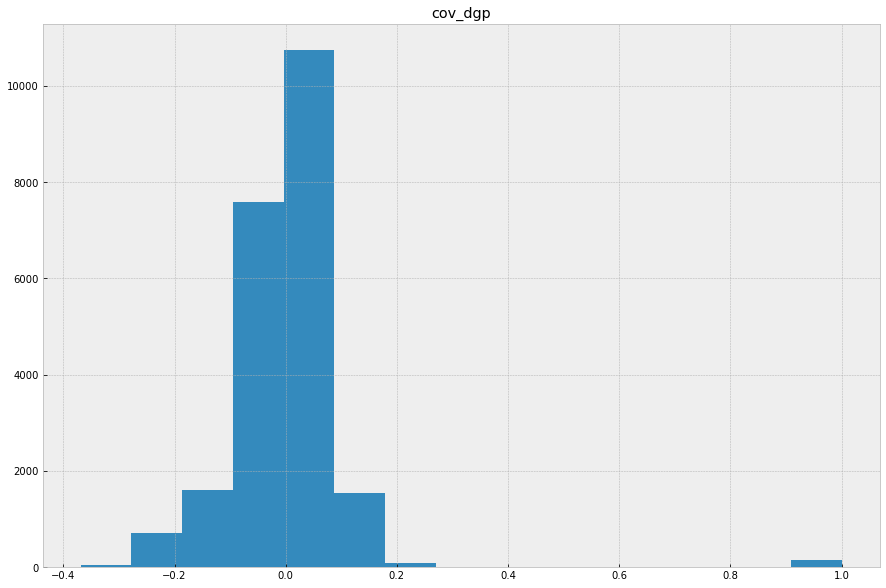

In [9]:
train_data[["cov_dgp"]].hist(bins=15)

## Model

### 1) Definition and Estimation

We will use the "LinearRegrssion" object of the sklearn package to define the linear regression model object. Since this model has no hyperparameters, we go straight to the estimation of the model parameters on the training data.

In [12]:
from scipy.stats import reciprocal
import numpy as np

def FFNN(n_hidden,
         n_neurons,
         input_shape,
         learning_rate,
         activation,
         loss):
    model = keras.models.Sequential()
    model.add(keras.layers.InputLayer(input_shape=input_shape))

    for layer in range(n_hidden):
        model.add(keras.layers.Dense(n_neurons, activation=activation))
    model.add(keras.layers.Dense(1))

    optimizer = keras.optimizers.SGD(lr=learning_rate)
    model.compile(loss=loss, optimizer=optimizer)

    return model

class FFNNWrapper():
    def __init__(self, model_params=None):
        self.model_name = "ffnn"
        self.search_type = 'random'
        self.param_grid = {"n_hidden": [1, 2, 3, 4, 5],
                           "n_neurons": np.arange(1, 100+1),
                           "learning_rate": reciprocal(3e-4, 3e-2),
                           "activation": ["relu"],
                           "loss": ["mse"]}
        self.ModelClass = keras.wrappers.scikit_learn.KerasRegressor(FFNN)

        if model_params is not None:
            self.param_grid.update(model_params)

In [13]:
from sklearn.metrics import mean_squared_error, make_scorer
from sklearn.model_selection import RandomizedSearchCV, KFold

cv_splits = KFold(n_splits=N_SPLITS)
mse_scorer = make_scorer(mean_squared_error)

wrapper = FFNNWrapper(model_params={"input_shape": [X_train_zscore.shape[1]]})

model_search = RandomizedSearchCV(estimator=wrapper.ModelClass,
                                  param_distributions=wrapper.param_grid,
                                  n_iter=N_ITER,
                                  cv=cv_splits,
                                  verbose=0,
                                  n_jobs=N_JOBS,
                                  scoring=mse_scorer,
                                  random_state=SEED) 

In [ ]:
opt_model_search = model_search.fit(X_train_zscore,
                                    y_train,
                                    epochs=50,
                                    callbacks=[keras.callbacks.EarlyStopping(patience=10)],
                                    validation_data=(X_validation_zscore, y_validation))

Train on 14174 samples, validate on 6751 samples
Epoch 1/50
14174/14174 [==============================] - 1s 59us/sample - loss: 0.0973 - val_loss: 0.0562
Epoch 2/50
14174/14174 [==============================] - 1s 36us/sample - loss: 0.0485 - val_loss: 0.0321
Epoch 3/50
14174/14174 [==============================] - 1s 36us/sample - loss: 0.0302 - val_loss: 0.0214
Epoch 4/50
14174/14174 [==============================] - 1s 36us/sample - loss: 0.0209 - val_loss: 0.0154
Epoch 5/50
14174/14174 [==============================] - 1s 37us/sample - loss: 0.0154 - val_loss: 0.0118
Epoch 6/50
14174/14174 [==============================] - 1s 42us/sample - loss: 0.0118 - val_loss: 0.0093
Epoch 7/50
14174/14174 [==============================] - 1s 35us/sample - loss: 0.0095 - val_loss: 0.0077
Epoch 8/50
14174/14174 [==============================] - 1s 36us/sample - loss: 0.0078 - val_loss: 0.0066
Epoch 9/50
14174/14174 [==============================] - 1s 37us/sample - loss: 0.0067 - val_l

### 2) Results

#### Training parameters

In [15]:
model_search

RandomizedSearchCV(cv=KFold(n_splits=10, random_state=None, shuffle=False),
                   error_score='raise-deprecating',
                   estimator=<tensorflow.python.keras.wrappers.scikit_learn.KerasRegressor object at 0x7fa72206bc88>,
                   iid='warn', n_iter=50, n_jobs=1,
                   param_distributions={'activation': ['relu'],
                                        'input_shape': [1],
                                        'learning_rate': <scipy.stats._distn_infrastructure.rv_froze...
        27,  28,  29,  30,  31,  32,  33,  34,  35,  36,  37,  38,  39,
        40,  41,  42,  43,  44,  45,  46,  47,  48,  49,  50,  51,  52,
        53,  54,  55,  56,  57,  58,  59,  60,  61,  62,  63,  64,  65,
        66,  67,  68,  69,  70,  71,  72,  73,  74,  75,  76,  77,  78,
        79,  80,  81,  82,  83,  84,  85,  86,  87,  88,  89,  90,  91,
        92,  93,  94,  95,  96,  97,  98,  99, 100])},
                   pre_dispatch='2*n_jobs', random_state=22

#### Hyperparameter grid

In [16]:
opt_model_search.param_distributions

{'n_hidden': [1, 2, 3, 4, 5],
 'n_neurons': array([  1,   2,   3,   4,   5,   6,   7,   8,   9,  10,  11,  12,  13,
         14,  15,  16,  17,  18,  19,  20,  21,  22,  23,  24,  25,  26,
         27,  28,  29,  30,  31,  32,  33,  34,  35,  36,  37,  38,  39,
         40,  41,  42,  43,  44,  45,  46,  47,  48,  49,  50,  51,  52,
         53,  54,  55,  56,  57,  58,  59,  60,  61,  62,  63,  64,  65,
         66,  67,  68,  69,  70,  71,  72,  73,  74,  75,  76,  77,  78,
         79,  80,  81,  82,  83,  84,  85,  86,  87,  88,  89,  90,  91,
         92,  93,  94,  95,  96,  97,  98,  99, 100]),
 'learning_rate': <scipy.stats._distn_infrastructure.rv_frozen at 0x7fa72206b978>,
 'activation': ['relu'],
 'loss': ['mse'],
 'input_shape': [1]}

#### Optimal parameters

In [17]:
opt_model_search.best_params_

{'activation': 'relu',
 'input_shape': 1,
 'learning_rate': 0.00042483042195542856,
 'loss': 'mse',
 'n_hidden': 1,
 'n_neurons': 30}

#### CV results

In [18]:
opt_model_search.cv_results_.keys()

dict_keys(['mean_fit_time', 'std_fit_time', 'mean_score_time', 'std_score_time', 'param_activation', 'param_input_shape', 'param_learning_rate', 'param_loss', 'param_n_hidden', 'param_n_neurons', 'params', 'split0_test_score', 'split1_test_score', 'split2_test_score', 'split3_test_score', 'split4_test_score', 'split5_test_score', 'split6_test_score', 'split7_test_score', 'split8_test_score', 'split9_test_score', 'mean_test_score', 'std_test_score', 'rank_test_score'])

In [20]:
# opt_model_search.cv_results_['split0_test_score']

<AxesSubplot:>

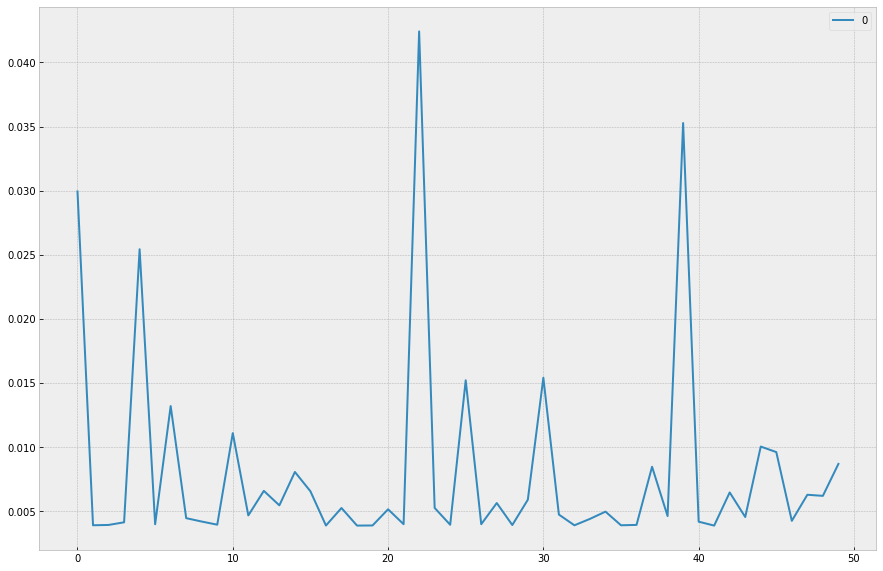

In [21]:
pd.DataFrame(opt_model_search.cv_results_['mean_test_score']).plot()

### 3) OOS prediction

In [22]:
test_pred = model_search.best_estimator_.predict(X_test_zscore)
output = pd.DataFrame({"Var1": test_data.reset_index()["Var1"],
                       "Var2": test_data.reset_index()["Var2"],
                       "y": y_test.ravel(),
                       "pred": test_pred.ravel()})

mse = mean_squared_error(y_true=output["y"],
                         y_pred=output["pred"])

In [23]:
output.tail()

,Var1,Var2,y,pred
22495,150,146,0.000000,-0.086576
22496,150,147,-0.185358,-0.187610
22497,150,148,0.000000,0.029961
22498,150,149,0.000000,-0.166191
22499,150,150,0.000000,-1.610771


In [24]:
mse

0.02765338317273578

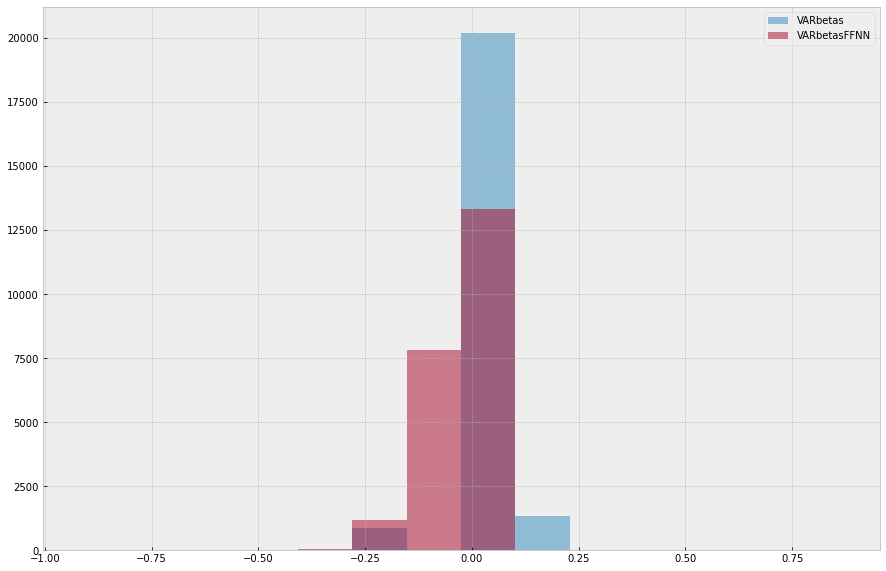

In [25]:
bins = np.linspace(np.min(np.array(output['y'].min(), output['pred'].min())),
                   np.min(np.array(output['y'].max(), output['pred'].max())),
                   15)
plt.hist(output['y'], bins, alpha=0.5, label='VARbetas')
plt.hist(output['pred'], bins, alpha=0.5, label='VARbetasFFNN')
plt.legend(loc='upper right')
plt.show()